In [277]:
import pandas as pd

# Load per-game player stats for 2024 season
url = "https://www.basketball-reference.com/leagues/NBA_2024_per_game.html"
tables = pd.read_html(url)
df = tables[0]

# Remove duplicate header rows
df = df[df["Player"] != "Player"]

# Maintain rowns without values as well
df = df.reset_index(drop=True)

# Preview
df.head()


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
0,1.0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,...,2.4,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7,AS
1,2.0,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,...,0.8,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,CPOY-6,AS,NBA1"
2,3.0,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,...,2.7,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,"MVP-4,DPOY-9,CPOY-12,AS,NBA1"
3,4.0,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,...,0.9,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,"MVP-2,DPOY-7,CPOY-3,AS,NBA1"
4,5.0,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,...,0.6,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,"MVP-5,CPOY-5,AS,NBA2"


In [240]:
# Define your features
features = [
    "PTS", "AST", "ORB", "DRB", "STL", "BLK", "TOV",
    "FG%", "3P%", "FT%", "MP"
]

# Extract and clean features (but keep missing values)
X = df[features].copy()
X = X.apply(pd.to_numeric, errors="coerce")  # coerce invalid strings to NaN
X = X.reset_index(drop=True)

# Preview the feature matrix (may still have NaNs, which is fine!)
X.head()


,PTS,AST,ORB,DRB,STL,BLK,TOV,FG%,3P%,FT%,MP
0,34.7,5.6,2.4,8.6,1.2,1.7,3.8,0.529,0.388,0.883,33.6
1,33.9,9.8,0.8,8.4,1.4,0.5,4.0,0.487,0.382,0.786,37.5
2,30.4,6.5,2.7,8.8,1.2,1.1,3.4,0.611,0.274,0.657,35.2
3,30.1,6.2,0.9,4.7,2.0,0.9,2.2,0.535,0.353,0.874,34.0
4,28.7,6.7,0.6,3.1,0.9,0.2,2.4,0.479,0.401,0.847,35.4


In [275]:
from sklearn.ensemble import RandomForestClassifier

# Simulate "clusters" using KMeans just to label training data
from sklearn.cluster import KMeans

# Use KMeans ONCE to define initial labels (unsupervised pretraining)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X.fillna(0))  # Temporarily fill NaNs for clustering
initial_labels = kmeans.labels_

# Train a Random Forest to predict these labels using raw features (NaNs / NA inclusive)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, initial_labels)  # This works even with NaNs

# Predict clusters for all players (including those with missing stats)
predicted_labels = rf_model.predict(X)

# Create DataFrame
player_names = df.loc[X.index, "Player"].tolist()
cluster_df = pd.DataFrame({
    "Player": player_names,
    "Cluster": predicted_labels
})

# Preview cluster distribution
for i in range(num_clusters):
    players_in_cluster = cluster_df[cluster_df["Cluster"] == i]["Player"].tolist()
    print(f"Cluster {i + 1} ({len(players_in_cluster)} players): {players_in_cluster[:10]}...")


Cluster 1 (159 players): ['Bojan Bogdanović', 'Cam Whitmore', 'Marvin Bagley III', 'Marvin Bagley III', 'Cole Anthony', 'Brandon Clarke', 'Zach Collins', 'Russell Westbrook', 'Daniel Gafford', 'Moritz Wagner']...
Cluster 2 (145 players): ['RJ Barrett', 'Terry Rozier', 'Collin Sexton', 'Klay Thompson', 'Jordan Poole', 'Brandon Miller', 'Jordan Clarkson', 'Myles Turner', 'Immanuel Quickley', 'Immanuel Quickley']...
Cluster 3 (74 players): ['Joel Embiid', 'Luka Dončić', 'Giannis Antetokounmpo', 'Shai Gilgeous-Alexander', 'Jalen Brunson', 'Devin Booker', 'Kevin Durant', 'Jayson Tatum', "De'Aaron Fox", 'Donovan Mitchell']...
Cluster 4 (207 players): ['Alec Burks', 'Tre Mann', 'Tristan Vukcevic', 'RaiQuan Gray', 'Cameron Payne', 'Jaden Hardy', 'Lamar Stevens', 'Landry Shamet', 'Vasilije Micić', 'Jordan Nwora']...
Cluster 5 (151 players): ['Dalano Banton', 'Lamar Stevens', 'Trey Jemison', 'Dāvis Bertāns', 'David Roddy', 'Daniel Theis', 'Danilo Gallinari', 'Malachi Flynn', 'Dexter Dennis', 'Da

In [201]:
# Merge Random Forest cluster labels into original dataframe
df_with_clusters = df.copy()
df_with_clusters["Cluster"] = None
df_with_clusters.loc[X.index, "Cluster"] = predicted_labels

# Now compute cluster-wise averages of the features
cluster_summary = df_with_clusters.groupby("Cluster")[features].mean().round(2)

# Display the result
cluster_summary


,PTS,AST,ORB,DRB,STL,BLK,TOV,FG%,3P%,FT%,MP
Cluster,,,,,,,,,,,
0,7.46,1.86,1.04,2.70,0.69,0.47,0.91,0.46,0.33,0.75,20.62
1,12.83,2.96,1.20,3.78,0.86,0.59,1.47,0.48,0.35,0.79,28.60
2,22.62,5.32,1.11,4.93,1.05,0.62,2.45,0.48,0.37,0.82,34.05
3,4.42,1.14,0.67,1.66,0.45,0.30,0.56,0.45,0.30,0.73,13.09
4,1.81,0.45,0.30,0.65,0.17,0.10,0.26,0.39,0.26,0.69,5.29


In [229]:
# Make sure example_player matches X’s column order
example_player = pd.Series({
    "PTS": 24.0,
    "AST": 5.0,
    "ORB": 1.0,
    "DRB": 5.0,
    "STL": 1.2,
    "BLK": 0.5,
    "TOV": 2.5,
    "FG%": 0.48,
    "3P%": 0.35,
    "FT%": 0.80,
    "MP": 32.0
})[X.columns]  # This ensures proper order

# Predict directly using raw stats
predicted_cluster = rf_model.predict(example_player.to_frame().T)[0]

# Map cluster to label
cluster_labels = {
    0: "Low-Usage Role Player",
    1: "Scoring Wing",
    2: "MVP-Caliber Star",
    3: "Defensive Big",
    4: "Inactive / Deep Bench"
}
archetype = cluster_labels[predicted_cluster]

print(f"The player is classified as: {archetype} (Cluster {predicted_cluster})")


The player is classified as: MVP-Caliber Star (Cluster 2)


In [273]:
# Add archetype labels to each cluster
# Manually defined based on reviewing `cluster_summary` values by General Assumptions (Open to more clusters and naming)
cluster_labels = {
    0: "Low-Usage Role Player",
    1: "Scoring Wing",
    2: "MVP-Caliber Star",
    3: "Defensive Big",
    4: "Inactive / Deep Bench"
}

# Add archetype label to each row in the cluster DataFrame
cluster_df["Archetype"] = cluster_df["Cluster"].map(cluster_labels)

# Reset index for clean presentation
cluster_df = cluster_df.reset_index(drop=True)

# Preview result
cluster_df.head()


,Player,Cluster,Archetype
0,Joel Embiid,2,MVP-Caliber Star
1,Luka Dončić,2,MVP-Caliber Star
2,Giannis Antetokounmpo,2,MVP-Caliber Star
3,Shai Gilgeous-Alexander,2,MVP-Caliber Star
4,Jalen Brunson,2,MVP-Caliber Star


In [269]:
from scipy.spatial.distance import cdist

# Define a new example player
example_player = pd.Series({
    "PTS": 24.0,
    "AST": 5.0,
    "ORB": 1.0,
    "DRB": 5.0,
    "STL": 1.2,
    "BLK": 0.5,
    "TOV": 2.5,
    "FG%": 0.48,
    "3P%": 0.35,
    "FT%": 0.80,
    "MP": 32.0
})[X.columns]  # Keep the column order consistent

# Predict cluster using random forest
predicted_cluster = rf_model.predict(example_player.to_frame().T)[0]

# Filter players in the same cluster
cluster_players = X[cluster_df["Cluster"] == predicted_cluster]
cluster_names = cluster_df[cluster_df["Cluster"] == predicted_cluster]["Player"].reset_index(drop=True)

# Compute distances from the example player to each in-cluster player
distances = cdist([example_player], cluster_players)[0]

# Get top N most similar players
N = 5
closest_indices = distances.argsort()[:N]
similar_players = cluster_names.iloc[closest_indices]

# Output
print(f"Based on their stat profile, the player fits into Cluster {predicted_cluster} ({cluster_labels[predicted_cluster]}).")
print("Most similar players in that cluster:")
print(similar_players.to_list())


Based on their stat profile, the player fits into Cluster 2 (MVP-Caliber Star).
Most similar players in that cluster:
['Zion Williamson', 'Kyle Kuzma', 'Jaylen Brown', 'Stephen Curry', 'Paul George']


🔍 Contribution of each stat to PC1 and PC2:


,PC1,PC2
PTS,0.526984,0.827597
AST,0.121056,0.114958
ORB,0.027099,-0.046997
DRB,0.119705,-0.012664
STL,0.024791,-0.023819
BLK,0.015901,-0.020264
TOV,0.055864,0.065743
FG%,0.002647,0.002137
3P%,0.002813,0.001371
FT%,0.002827,0.006420


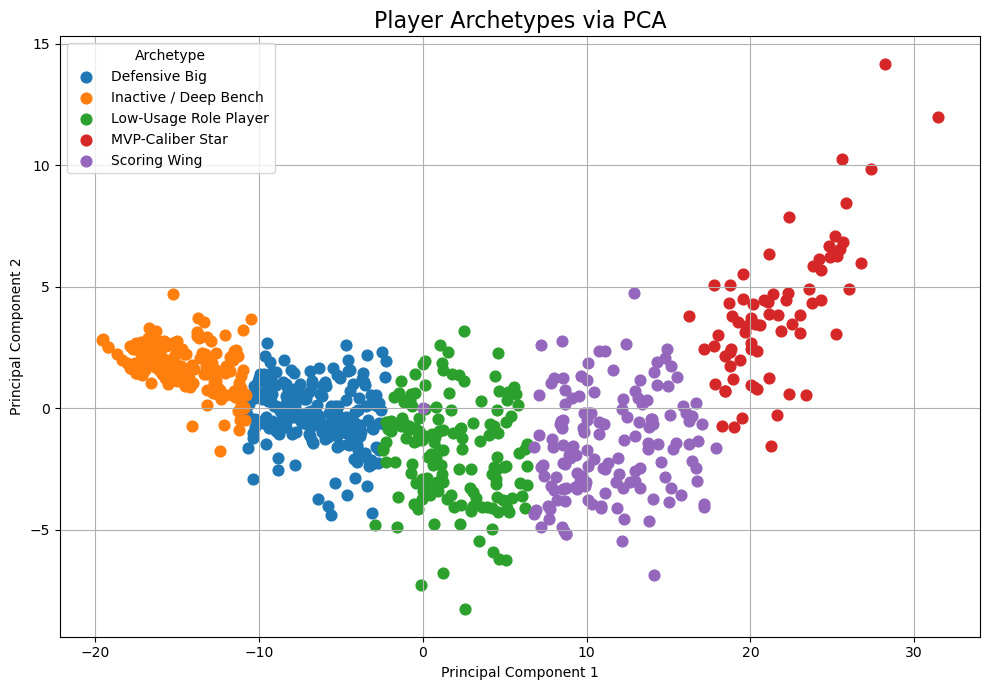

In [271]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Reduce unscaled X to 2D using PCA (NaNs are filled temporarily for visualization)
X_filled = X.fillna(X.mean(numeric_only=True))  # Fill with mean for PCA visualization only
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filled)

# Show stat weight for PC declaration
pc_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=["PC1", "PC2"]
).T

print("🔍 Contribution of each stat to PC1 and PC2:")
display(pc_components)

# Build DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Archetype"] = cluster_df["Archetype"].values

# Plot dataset from DataFrame
plt.figure(figsize=(10, 7))
for label in sorted(pca_df["Archetype"].unique()):
    subset = pca_df[pca_df["Archetype"] == label]
    plt.scatter(subset["PC1"], subset["PC2"], label=label, s=60)

plt.title("Player Archetypes via PCA", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Archetype")
plt.grid(True)
plt.tight_layout()
plt.show()


In [281]:
# Test run AI archetype classifier
from scipy.spatial.distance import cdist

user_input = input("Enter an NBA player name OR type 'custom' to input stats manually: ").strip()

if user_input.lower() != "custom":
    # Look up player in dataset
    match = df[df["Player"].str.lower() == user_input.lower()]
    
    if match.empty:
        print("Player not found. Please try again.")
    else:
        player_stats = match[features].iloc[0]
        prediction = rf_model.predict(player_stats.to_frame().T)[0]
        archetype = cluster_labels[prediction]
        
        print(f"\n{user_input} is classified as: {archetype} ({prediction})")

        # Find similar players
        cluster_indices = cluster_df[cluster_df["Cluster"] == prediction].index
        cluster_players = X.loc[cluster_indices]
        cluster_names = cluster_df.loc[cluster_indices, "Player"]

        # Exclude the input player from the list (case-insensitive)
        mask = cluster_names.str.lower() != user_input.lower()
        filtered_cluster_players = cluster_players[mask]
        filtered_cluster_names = cluster_names[mask]
        
        # Compute distances
        distances = cdist([player_stats.fillna(X.mean())], filtered_cluster_players.fillna(X.mean()))[0]
        top_similar = filtered_cluster_names.iloc[distances.argsort()[:5]].tolist()

        print("\n📊 Most similar players in the same archetype:")
        for name in top_similar:
            print("•", name)

else:
    # Ask user to input a custom stat line
    print("\n📝 Enter the following stats (leave blank to skip):")
    custom_stats = {}
    for stat in features:
        val = input(f"{stat}: ")
        custom_stats[stat] = float(val) if val.strip() else None

    player_series = pd.Series(custom_stats)[X.columns]
    prediction = rf_model.predict(player_series.to_frame().T)[0]
    archetype = cluster_labels[prediction]
    
    print(f"\n✅ The custom player is classified as: {archetype} ({prediction})")

    # Find similar players
    cluster_indices = cluster_df[cluster_df["Cluster"] == prediction].index
    cluster_players = X.loc[cluster_indices]
    cluster_names = cluster_df.loc[cluster_indices, "Player"]
    
    # No need to exclude a named player for custom mode
    distances = cdist([player_series.fillna(X.mean())], cluster_players.fillna(X.mean()))[0]
    top_similar = cluster_names.iloc[distances.argsort()[:5]].tolist()
    
    print("\n Most similar players in the same archetype:")
    for name in top_similar:
        print("•", name)


Enter an NBA player name OR type 'custom' to input stats manually:  LeBron James



LeBron James is classified as: MVP-Caliber Star (2)

📊 Most similar players in the same archetype:
• Ja Morant
• Donovan Mitchell
• Damian Lillard
• Devin Booker
• Anthony Edwards
